In [1]:
# Imports modules

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

print("Environment ready!")
print("Pandas version:", pd.__version__)


Environment ready!
Pandas version: 2.3.3


In [2]:
#Load CSV, handle missing values

dataPath = "../data/"

na_vals = ["\\N"]  

races        = pd.read_csv(dataPath + "races.csv",        na_values=na_vals)
drivers      = pd.read_csv(dataPath + "drivers.csv",      na_values=na_vals)
constructors = pd.read_csv(dataPath + "constructors.csv", na_values=na_vals)
results      = pd.read_csv(dataPath + "results.csv",      na_values=na_vals)
circuits     = pd.read_csv(dataPath + "circuits.csv",     na_values=na_vals)
status       = pd.read_csv(dataPath + "status.csv",       na_values=na_vals)
qualifying   = pd.read_csv(dataPath + "qualifying.csv",   na_values=na_vals)
lap_times    = pd.read_csv(dataPath + "lap_times.csv",    na_values=na_vals)
pit_stops    = pd.read_csv(dataPath + "pit_stops.csv",    na_values=na_vals)

print("loaded tables: ")
for name, df in [
    ("races", races),
    ("drivers", drivers),
    ("constructors", constructors),
    ("results", results),
    ("circuits", circuits),
    ("status", status),
    ("qualifying", qualifying),
    ("lap_times", lap_times),
    ("pit_stops", pit_stops),
]:
    print(f"{name:12} -> {df.shape[0]:6} rows, {df.shape[1]:3} columns")


loaded tables: 
races        ->   1125 rows,  18 columns
drivers      ->    861 rows,   9 columns
constructors ->    212 rows,   5 columns
results      ->  26759 rows,  18 columns
circuits     ->     77 rows,   9 columns
status       ->    139 rows,   2 columns
qualifying   ->  10494 rows,   9 columns
lap_times    -> 589081 rows,   6 columns
pit_stops    ->  11371 rows,   7 columns


In [3]:
#Limit the data to the hybrid era

MIN_YEAR = 2014

races = races[races["year"] >= MIN_YEAR].copy()
valid_race_ids = races["raceId"].unique()

results    = results[results["raceId"].isin(valid_race_ids)].copy()
qualifying = qualifying[qualifying["raceId"].isin(valid_race_ids)].copy()
lap_times  = lap_times[lap_times["raceId"].isin(valid_race_ids)].copy()
pit_stops  = pit_stops[pit_stops["raceId"].isin(valid_race_ids)].copy()

print("After filtering to >= 2014:")
for name, df_raw in [
    ("races", races),
    ("results", results),
    ("qualifying", qualifying),
    ("lap_times", lap_times),
    ("pit_stops", pit_stops),
]:
    print(f"{name:11} -> {df_raw.shape[0]:6} rows")


After filtering to >= 2014:
races       ->    228 rows
results     ->   4626 rows
qualifying  ->   4610 rows
lap_times   -> 248144 rows
pit_stops   ->   8360 rows


In [4]:
#Rename columns for clarity

races_renamed = races.rename(columns={
    "name": "race_name",
    "date": "race_date"
})

results_renamed = results.rename(columns={
    "positionOrder": "finishing_position"
})

drivers_renamed = drivers.rename(columns={
    "forename": "driver_forename",
    "surname": "driver_surname",
    "dob": "driver_dob",
    "nationality": "driver_nationality",
    "code": "driver_code"
})

constructors_renamed = constructors.rename(columns={
    "name": "constructors_name",
    "nationality": "constructor_nationality"
})

circuits_renamed = circuits.rename(columns={
    "name": "circuit_name"
})


In [5]:
#Merge race info into results

df = results_renamed.merge(
    races_renamed[["raceId", "year", "round", "race_name", "circuitId", "race_date"]],
    on="raceId",
    how="left"
)

print("results_renamed shape:", results_renamed.shape)
print("df shape after races: ", df.shape)
df.head()


results_renamed shape: (4626, 18)
df shape after races:  (4626, 23)


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,finishing_position,points,...,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,year,round,race_name,circuitId,race_date
0,22130,900,3,131,6.0,3,1.0,1,1,25.0,...,19.0,1.0,1:32.478,206.436,1,2014,1,Australian Grand Prix,1,2014-03-16
1,22131,900,825,1,20.0,4,2.0,2,2,18.0,...,49.0,6.0,1:33.066,205.131,1,2014,1,Australian Grand Prix,1,2014-03-16
2,22132,900,18,1,22.0,10,3.0,3,3,15.0,...,39.0,5.0,1:32.917,205.460,1,2014,1,Australian Grand Prix,1,2014-03-16
3,22133,900,4,6,14.0,5,4.0,4,4,12.0,...,57.0,7.0,1:33.186,204.867,1,2014,1,Australian Grand Prix,1,2014-03-16
4,22134,900,822,3,77.0,15,5.0,5,5,10.0,...,56.0,3.0,1:32.616,206.128,1,2014,1,Australian Grand Prix,1,2014-03-16


In [6]:
#Merge driver info

df = df.merge(
    drivers_renamed[[
        "driverId",
        "driver_forename",
        "driver_surname",
        "driver_dob",
        "driver_nationality",
        "driver_code"
    ]],
    on="driverId",
    how="left"
)

print("df shape after adding drivers:", df.shape)
df.head()


df shape after adding drivers: (4626, 28)


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,finishing_position,points,...,year,round,race_name,circuitId,race_date,driver_forename,driver_surname,driver_dob,driver_nationality,driver_code
0,22130,900,3,131,6.0,3,1.0,1,1,25.0,...,2014,1,Australian Grand Prix,1,2014-03-16,Nico,Rosberg,1985-06-27,German,ROS
1,22131,900,825,1,20.0,4,2.0,2,2,18.0,...,2014,1,Australian Grand Prix,1,2014-03-16,Kevin,Magnussen,1992-10-05,Danish,MAG
2,22132,900,18,1,22.0,10,3.0,3,3,15.0,...,2014,1,Australian Grand Prix,1,2014-03-16,Jenson,Button,1980-01-19,British,BUT
3,22133,900,4,6,14.0,5,4.0,4,4,12.0,...,2014,1,Australian Grand Prix,1,2014-03-16,Fernando,Alonso,1981-07-29,Spanish,ALO
4,22134,900,822,3,77.0,15,5.0,5,5,10.0,...,2014,1,Australian Grand Prix,1,2014-03-16,Valtteri,Bottas,1989-08-28,Finnish,BOT


In [7]:
#Merge constructor info

df = df.merge(
    constructors_renamed[[
        "constructorId",
        "constructors_name",
        "constructor_nationality"
    ]],
    on="constructorId",
    how="left"
)

print("df shape after adding constructors:", df.shape)
df.head()


df shape after adding constructors: (4626, 30)


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,finishing_position,points,...,race_name,circuitId,race_date,driver_forename,driver_surname,driver_dob,driver_nationality,driver_code,constructors_name,constructor_nationality
0,22130,900,3,131,6.0,3,1.0,1,1,25.0,...,Australian Grand Prix,1,2014-03-16,Nico,Rosberg,1985-06-27,German,ROS,Mercedes,German
1,22131,900,825,1,20.0,4,2.0,2,2,18.0,...,Australian Grand Prix,1,2014-03-16,Kevin,Magnussen,1992-10-05,Danish,MAG,McLaren,British
2,22132,900,18,1,22.0,10,3.0,3,3,15.0,...,Australian Grand Prix,1,2014-03-16,Jenson,Button,1980-01-19,British,BUT,McLaren,British
3,22133,900,4,6,14.0,5,4.0,4,4,12.0,...,Australian Grand Prix,1,2014-03-16,Fernando,Alonso,1981-07-29,Spanish,ALO,Ferrari,Italian
4,22134,900,822,3,77.0,15,5.0,5,5,10.0,...,Australian Grand Prix,1,2014-03-16,Valtteri,Bottas,1989-08-28,Finnish,BOT,Williams,British


In [8]:
#Merge circuit info

df = df.merge(
    circuits_renamed[["circuitId", "circuit_name", "country"]],
    on="circuitId",
    how="left"
)

print("df shape after adding circuits:", df.shape)
df.head()


df shape after adding circuits: (4626, 32)


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,finishing_position,points,...,race_date,driver_forename,driver_surname,driver_dob,driver_nationality,driver_code,constructors_name,constructor_nationality,circuit_name,country
0,22130,900,3,131,6.0,3,1.0,1,1,25.0,...,2014-03-16,Nico,Rosberg,1985-06-27,German,ROS,Mercedes,German,Albert Park Grand Prix Circuit,Australia
1,22131,900,825,1,20.0,4,2.0,2,2,18.0,...,2014-03-16,Kevin,Magnussen,1992-10-05,Danish,MAG,McLaren,British,Albert Park Grand Prix Circuit,Australia
2,22132,900,18,1,22.0,10,3.0,3,3,15.0,...,2014-03-16,Jenson,Button,1980-01-19,British,BUT,McLaren,British,Albert Park Grand Prix Circuit,Australia
3,22133,900,4,6,14.0,5,4.0,4,4,12.0,...,2014-03-16,Fernando,Alonso,1981-07-29,Spanish,ALO,Ferrari,Italian,Albert Park Grand Prix Circuit,Australia
4,22134,900,822,3,77.0,15,5.0,5,5,10.0,...,2014-03-16,Valtteri,Bottas,1989-08-28,Finnish,BOT,Williams,British,Albert Park Grand Prix Circuit,Australia


In [9]:
#Merge status info

df = df.merge(
    status[["statusId", "status"]],
    on="statusId",
    how="left"
)

print("df shape after adding status:", df.shape)
df.head()


df shape after adding status: (4626, 33)


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,finishing_position,points,...,driver_forename,driver_surname,driver_dob,driver_nationality,driver_code,constructors_name,constructor_nationality,circuit_name,country,status
0,22130,900,3,131,6.0,3,1.0,1,1,25.0,...,Nico,Rosberg,1985-06-27,German,ROS,Mercedes,German,Albert Park Grand Prix Circuit,Australia,Finished
1,22131,900,825,1,20.0,4,2.0,2,2,18.0,...,Kevin,Magnussen,1992-10-05,Danish,MAG,McLaren,British,Albert Park Grand Prix Circuit,Australia,Finished
2,22132,900,18,1,22.0,10,3.0,3,3,15.0,...,Jenson,Button,1980-01-19,British,BUT,McLaren,British,Albert Park Grand Prix Circuit,Australia,Finished
3,22133,900,4,6,14.0,5,4.0,4,4,12.0,...,Fernando,Alonso,1981-07-29,Spanish,ALO,Ferrari,Italian,Albert Park Grand Prix Circuit,Australia,Finished
4,22134,900,822,3,77.0,15,5.0,5,5,10.0,...,Valtteri,Bottas,1989-08-28,Finnish,BOT,Williams,British,Albert Park Grand Prix Circuit,Australia,Finished


In [10]:
# Summarize pit stops per driver per race and merge

pit_summary = (
    pit_stops
    .groupby(["raceId", "driverId"])
    .agg(
        pit_stop_count=("stop", "count"),
        total_pit_time=("milliseconds", "sum")
    )
    .reset_index()
)

df = df.merge(pit_summary, on=["raceId", "driverId"], how="left")

print("df shape after adding pit features:", df.shape)
df[["raceId", "driverId", "pit_stop_count", "total_pit_time"]].head()


df shape after adding pit features: (4626, 35)


,raceId,driverId,pit_stop_count,total_pit_time
0,900,3,2.0,48004.0
1,900,825,2.0,45423.0
2,900,18,2.0,44810.0
3,900,4,2.0,44865.0
4,900,822,2.0,58038.0


In [11]:
#Summarize lap times per driver per race and merge

lap_summary = (
    lap_times
    .groupby(["raceId", "driverId"])
    .agg(
        lap_count=("lap", "count"),
        best_lap_ms=("milliseconds", "min"),
        avg_lap_ms=("milliseconds", "mean")
    )
    .reset_index()
)

df = df.merge(lap_summary, on=["raceId", "driverId"], how="left")

print("df shape after adding lap features:", df.shape)
df[["raceId", "driverId", "lap_count", "best_lap_ms", "avg_lap_ms"]].head()


df shape after adding lap features: (4626, 38)


,raceId,driverId,lap_count,best_lap_ms,avg_lap_ms
0,900,3,57.0,92478.0,97872.105263
1,900,825,57.0,92917.0,98341.877193
2,900,18,57.0,93186.0,98398.894737
3,900,4,57.0,92616.0,98491.122807
4,900,822,57.0,92568.0,98707.877193


In [12]:
#Prepare and merge qualifying info

qualifying_renamed = qualifying.rename(columns={"position": "quali_position"})

qualifying_renamed = qualifying_renamed[[
    "raceId",
    "driverId",
    "quali_position",
    "q1",
    "q2",
    "q3"
]]

df = df.merge(qualifying_renamed, on=["raceId", "driverId"], how="left")

print("df shape after adding qualifying features:", df.shape)
df[["raceId", "driverId", "grid", "quali_position", "finishing_position"]].head()


df shape after adding qualifying features: (4626, 42)


,raceId,driverId,grid,quali_position,finishing_position
0,900,3,3,3.0,1
1,900,825,4,4.0,2
2,900,18,10,11.0,3
3,900,4,5,5.0,4
4,900,822,15,10.0,5


In [13]:
#Create modeling dataframe and confirm numeric types

model_df = df.copy()

model_df = model_df.replace("\\N", np.nan)

model_df["quali_position"]     = pd.to_numeric(model_df["quali_position"], errors="coerce")
model_df["finishing_position"] = pd.to_numeric(model_df["finishing_position"], errors="coerce")
model_df["grid"]               = pd.to_numeric(model_df["grid"], errors="coerce")
model_df["total_pit_time"]     = pd.to_numeric(model_df["total_pit_time"], errors="coerce")
model_df["pit_stop_count"]     = pd.to_numeric(model_df["pit_stop_count"], errors="coerce")
model_df["best_lap_ms"]        = pd.to_numeric(model_df["best_lap_ms"], errors="coerce")
model_df["avg_lap_ms"]         = pd.to_numeric(model_df["avg_lap_ms"], errors="coerce")

model_df = model_df.dropna(subset=["quali_position", "finishing_position"])

print(model_df[["quali_position", "finishing_position"]].dtypes)
model_df[["raceId", "driverId", "grid", "quali_position", "finishing_position"]].head()


quali_position        float64
finishing_position      int64
dtype: object


,raceId,driverId,grid,quali_position,finishing_position
0,900,3,3,3.0,1
1,900,825,4,4.0,2
2,900,18,10,11.0,3
3,900,4,5,5.0,4
4,900,822,15,10.0,5


       finishing_position  quali_position         grid  pit_stop_count  \
count         4610.000000     4610.000000  4610.000000     4285.000000   
mean            10.644902       10.625597    10.323644        1.946558   
std              5.874579        5.858529     5.908706        0.993532   
min              1.000000        1.000000     0.000000        1.000000   
25%              6.000000        6.000000     5.000000        1.000000   
50%             11.000000       11.000000    10.000000        2.000000   
75%             16.000000       16.000000    15.000000        2.000000   
max             22.000000       22.000000    22.000000        7.000000   

       total_pit_time    best_lap_ms     avg_lap_ms  
count    4.285000e+03    4473.000000    4473.000000  
mean     2.089703e+05   91206.620613  100700.948028  
std      5.616008e+05   15773.914047   25879.345162  
min      1.743400e+04   55404.000000   62932.344828  
25%      2.517600e+04   80665.000000   85799.922078  
50%      

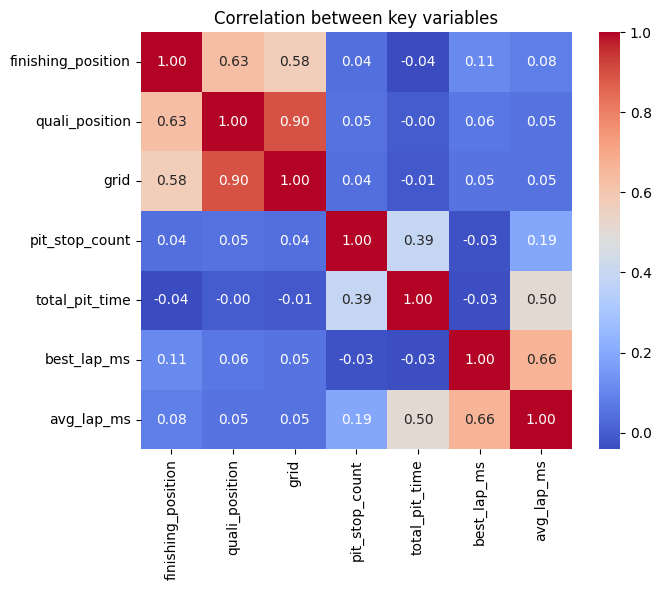

In [14]:
#EDA for numeric predictors vs finishing_position

numeric_cols = [
    "finishing_position",
    "quali_position",
    "grid",
    "pit_stop_count",
    "total_pit_time",
    "best_lap_ms",
    "avg_lap_ms"
]

print(model_df[numeric_cols].describe())

corr = model_df[numeric_cols].corr()
print("\nCorrelation matrix:\n", corr)

plt.figure(figsize=(7, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation between key variables")
plt.tight_layout()
plt.show()


Average finishing position for constructors (>= 50 race results):


constructors_name
Mercedes           4.614035
Red Bull           6.491189
Ferrari            6.807018
Force India       10.005000
McLaren           10.293598
Racing Point      10.631579
Aston Martin      11.155556
Alpine F1 Team    11.222222
Renault           12.203046
AlphaTauri        12.373494
Toro Rosso        12.807531
Williams          13.208791
Alfa Romeo        13.376812
Lotus F1          13.842105
Haas F1 Team      14.213720
Sauber            14.712551
Manor Marussia    16.868421
Name: finishing_position, dtype: float64

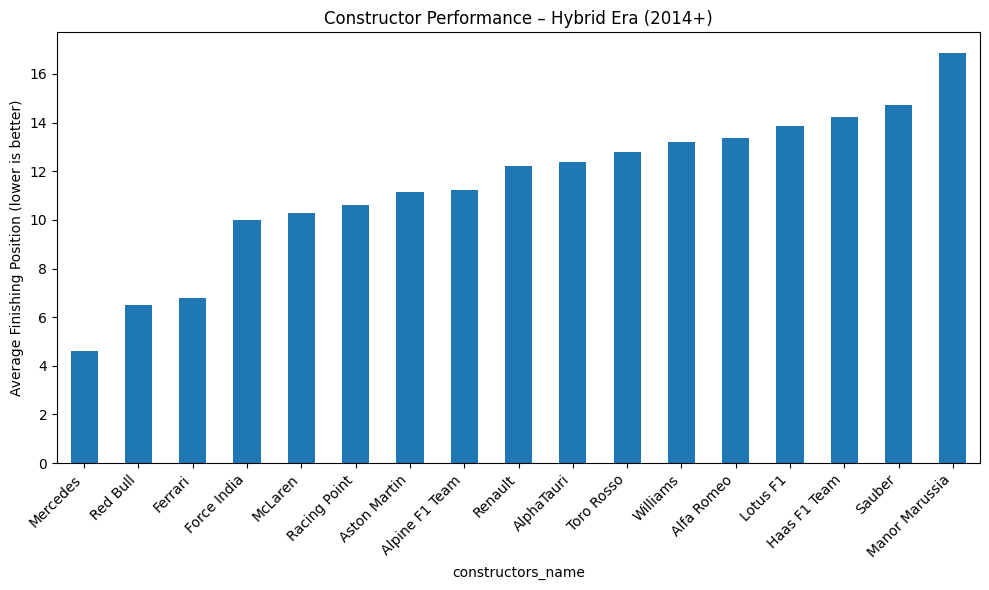

Average finishing position for drivers (>= 25 race results):


driver_forename  driver_surname
Nico             Rosberg            3.762712
Lewis            Hamilton           3.991189
Max              Verstappen         5.645933
Sebastian        Vettel             7.553073
Charles          Leclerc            7.557047
Lando            Norris             7.851562
Oscar            Piastri            7.891304
Valtteri         Bottas             8.513158
Sergio           Pérez              8.561947
Carlos           Sainz              9.241546
Daniel           Ricciardo          9.257282
Kimi             Räikkönen          9.417722
Felipe           Massa             10.064103
George           Russell           10.531250
Fernando         Alonso            10.768817
Esteban          Ocon              11.180645
Pierre           Gasly             11.248366
Nico             Hülkenberg        11.860465
Jenson           Button            11.879310
Alexander        Albon             11.932692
Name: finishing_position, dtype: float64

In [15]:
#Constructor and driver average finishing positions

constructor_df = model_df.dropna(subset=["finishing_position", "constructors_name"])
constructor_counts = constructor_df["constructors_name"].value_counts()
big_teams = constructor_counts[constructor_counts >= 50].index  # threshold can be adjusted

constructor_avg_finish = (
    constructor_df[constructor_df["constructors_name"].isin(big_teams)]
    .groupby("constructors_name")["finishing_position"]
    .mean()
    .sort_values()
)

print("Average finishing position for constructors (>= 50 race results):")
display(constructor_avg_finish)

plt.figure(figsize=(10, 6))
constructor_avg_finish.plot(kind="bar")
plt.ylabel("Average Finishing Position (lower is better)")
plt.title("Constructor Performance – Hybrid Era (2014+)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

driver_df = model_df.dropna(subset=["finishing_position", "driver_surname"])
driver_counts = driver_df["driver_surname"].value_counts()
regular_drivers = driver_counts[driver_counts >= 25].index  # threshold can be adjusted

driver_avg_finish = (
    driver_df[driver_df["driver_surname"].isin(regular_drivers)]
    .groupby(["driver_forename", "driver_surname"])["finishing_position"]
    .mean()
    .sort_values()
)

print("Average finishing position for drivers (>= 25 race results):")
display(driver_avg_finish.head(20))


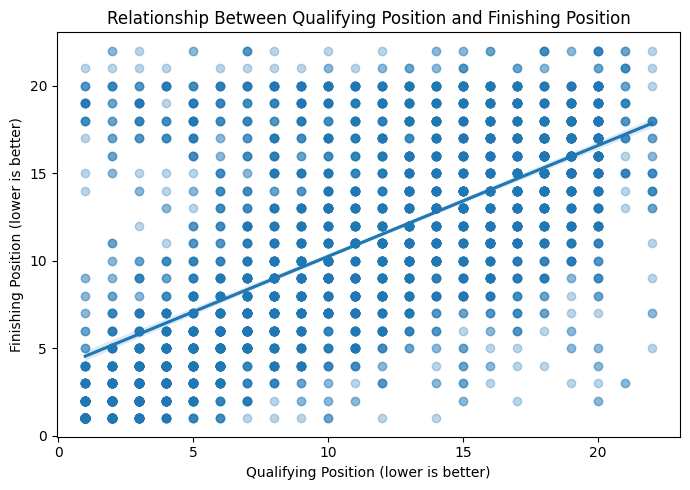

In [16]:
#Scatter + regression line for quali vs finishing position

plt.figure(figsize=(7, 5))
sns.regplot(
    data=model_df,
    x="quali_position",
    y="finishing_position",
    scatter_kws={"alpha": 0.3}
)
plt.xlabel("Qualifying Position (lower is better)")
plt.ylabel("Finishing Position (lower is better)")
plt.title("Relationship Between Qualifying Position and Finishing Position")
plt.tight_layout()
plt.show()


In [17]:
#Baseline regression with numeric features only

features = ["quali_position", "grid", "total_pit_time", "pit_stop_count"]

reg_df = model_df.dropna(subset=features + ["finishing_position"]).copy()

X = reg_df[features]
y = reg_df["finishing_position"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

linreg = LinearRegression()
linreg.fit(X_train, y_train)

print("Intercept:", linreg.intercept_)
print("\nCoefficients (effect on finishing_position):")
for name, coef in zip(features, linreg.coef_):
    print(f"{name:15} {coef: .6f}")

print("\nR^2 on training set:", linreg.score(X_train, y_train))
print("R^2 on test set:    ", linreg.score(X_test, y_test))


Intercept: 3.12857622107677

Coefficients (effect on finishing_position):
quali_position   0.599172
grid             0.052367
total_pit_time  -0.000001
pit_stop_count   0.081048

R^2 on training set: 0.46648654390685595
R^2 on test set:     0.4690622315235209


In [ ]:
#Regression including constructor dummies to capture team impact

reg_cons_df = model_df.dropna(subset=[
    "finishing_position",
    "quali_position",
    "grid",
    "total_pit_time",
    "pit_stop_count",
    "constructors_name"
]).copy()

constructor_dummies = pd.get_dummies(
    reg_cons_df["constructors_name"],
    prefix="team",
    drop_first=True
)

base_features = ["quali_position", "grid", "total_pit_time", "pit_stop_count"]
X_full = pd.concat([reg_cons_df[base_features], constructor_dummies], axis=1)
y_full = reg_cons_df["finishing_position"]

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42
)

linreg_cons = LinearRegression()
linreg_cons.fit(X_train_f, y_train_f)

print("R^2 (numeric-only model):",
      linreg.score(X_train, y_train),
      "(train) /",
      linreg.score(X_test, y_test),
      "(test)")
print("R^2 (with constructors):  ",
      linreg_cons.score(X_train_f, y_train_f),
      "(train) /",
      linreg_cons.score(X_test_f, y_test_f),
      "(test)")

coef_series = pd.Series(linreg_cons.coef_, index=X_full.columns)

print("\nBaseline numeric feature coefficients:")
print(coef_series[base_features])

print("\nConstructor coefficients (relative to dropped baseline team):")
constructor_effects = coef_series[constructor_dummies.columns].sort_values()
display(constructor_effects.head(10))
display(constructor_effects.tail(10))


R^2 (numeric-only model): 0.46648654390685595 (train) / 0.4690622315235209 (test)
R^2 (with constructors):   0.5228597578497721 (train) / 0.510956007268521 (test)

Baseline numeric feature coefficients:
quali_position    4.062499e-01
grid              4.635736e-02
total_pit_time   -4.794749e-07
pit_stop_count    9.207027e-02
dtype: float64

Constructor coefficients (relative to dropped baseline team):


team_Mercedes         -4.160612
team_Red Bull         -3.655903
team_Ferrari          -3.203271
team_Racing Point     -1.942267
team_Force India      -1.924135
team_McLaren          -1.496792
team_Aston Martin     -1.253450
team_Alpine F1 Team   -1.170524
team_Lotus F1         -0.483796
team_Renault          -0.451084
dtype: float64

team_Renault          -0.451084
team_AlphaTauri       -0.028689
team_Williams          0.114738
team_Toro Rosso        0.163145
team_Sauber            0.352289
team_Marussia          0.892889
team_RB F1 Team        1.077447
team_Haas F1 Team      1.095298
team_Caterham          1.123365
team_Manor Marussia    1.146716
dtype: float64